<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2025/blob/main/DL%20Lab%20-%20Transforming%20Radiology%20with%20LLMs%20-%20Fine-Tuning%20and%20Explainable%20AI%20for%20Next-Gen%20Clinical%20Solutions/DLL008_LAB_RSNA_llm_finetuning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2025 Deep Learning Lab - <font color="red">Finetune</font> LLM Tutorial**

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<!-- <div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div> -->

<!-- To install Unsloth your local device, follow [our guide](https://docs.unsloth.ai/get-started/install-and-update). This notebook is licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme). -->

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


#<font color="yellow">STEP 1: Package Installation</font>


Before running the notebook, we install all required packages.


<font color="orange">⏳ This step may take a few minutes… **Estimated Time:** 1-2 minutes</font>


Before running the notebook, we'll install all required deep learning packages and dependencies.

---

### Packages Being Installed


🔥 **[Unsloth](https://github.com/unslothai/unsloth)**
<span style="color: #4CAF50;">**Primary fine-tuning framework**</span> - Provides 2-5x faster training and 80% less memory usage.


🎯 **[TRL](https://github.com/huggingface/trl)** - Transformer Reinforcement Learning - supervised fine-tuning (SFT) and alignment.

💾 **[BitsAndBytes](https://github.com/TimDettmers/bitsandbytes)**
<span style="color: #FF9800;">**Memory optimization**</span> - Enables 4-bit and 8-bit quantization for training.

⚙️ **[PEFT](https://huggingface.co/docs/peft)** - Parameter-Efficient Fine-Tuning using
<span style="color: #F44336;">**LoRA implementation**</span>

🔧 **Supporting Libraries**
- **[Accelerate](https://huggingface.co/docs/accelerate)** - Multi-GPU and distributed training
- **[xformers](https://github.com/facebookresearch/xformers)** - Memory-efficient attention mechanisms
- **[Datasets](https://huggingface.co/docs/datasets)** - Dataset loading and processing
- **[Triton](https://github.com/openai/triton)** - GPU kernel optimization

---

In [1]:
%%capture
import os, re, json
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

#<font color="yellow">STEP 2: Model Loading</font>


Load the pre-trained language model with memory-efficient configurations.

<font color="orange">⏳ **Estimated Time:** 2-3 minutes</font>

---

### Configuration Settings

**🔢 Max Sequence Length:** 2048 tokens - Maximum input/output length per training example

**💾 4-bit Quantization:** Enabled - Reduces memory usage by 75% while maintaining performance

**🎯 Model:** Meta-Llama-3.1-8B - 8 billion parameter model from Meta


---

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

#<font color="yellow"> STEP 3: LoRA Configuration

Configure Parameter-Efficient Fine-Tuning (PEFT) using LoRA adapters.

<font color="orange">⏳ **Estimated Time:** < 30 seconds</font>

---

### Key Parameters

**🎯 Rank (r = 16)** - Size of LoRA adapter matrices. Higher = more capacity, more memory.
- Common values: 8, 16, 32, 64, 128

**📊 LoRA Alpha (16)** - Scaling factor for adapter weights. Typically set equal to rank.

**🎪 Target Modules** - Which model layers get LoRA adapters:
- Attention: <font color="orange">`q_proj`, `k_proj`, `v_proj`, `o_proj`</font>
- Feed-forward: <font color="orange">`gate_proj`, `up_proj`, `down_proj`</font>

**💾 Gradient Checkpointing** - "unsloth" mode saves 30% VRAM, fits 2x larger batches

**⚡ Optimizations**
- <font color="orange">`lora_dropout = 0`</font> - Disabled for faster training
- <font color="orange">`bias = "none"`</font> - Skip bias training for efficiency

---



In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.11.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


#<font color="yellow">STEP 4: Dataset Preparation </font>

Load and format the CT-RATE dataset for radiology report classification.

<font color="orange">⏳ **Estimated Time:** <1 minute</font>

---

### 📊 CT-RATE Dataset

**What it is:** Chest CT radiology reports with structured labels for 18 medical conditions
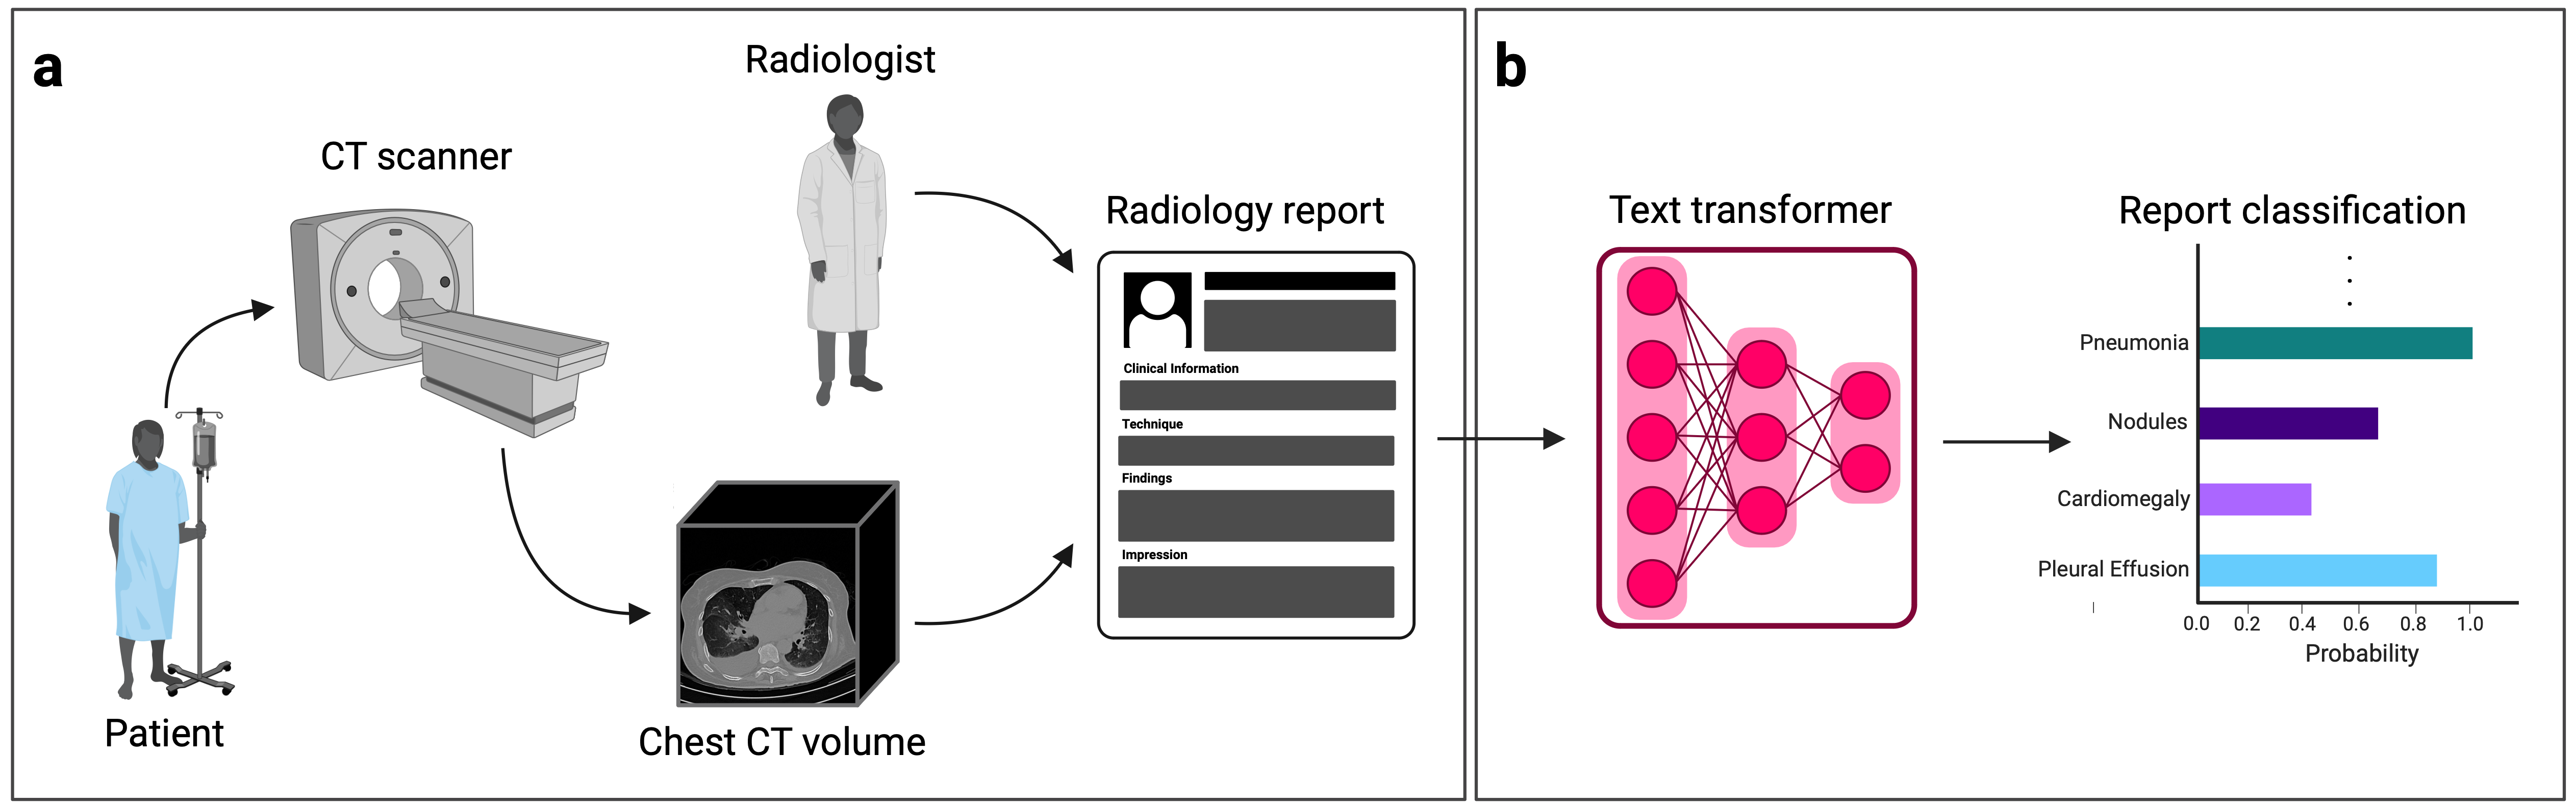


**Dataset size:**
- Training: 24,128 reports
- Test: 1,564 reports

**Source:**
- **Original Dataset:** [ibrahimhamamci/CT-RATE](https://huggingface.co/datasets/ibrahimhamamci/CT-RATE)
- **Using:** [dharmam-stjude/CT-RATE-Dataset-cleaned](https://huggingface.co/datasets/dharmam-stjude/CT-RATE-Dataset-cleaned)
  - Pre-processed with deduplication
  - Standardized report structure
  - Ready for training

---

### 🏷️ Medical Conditions (18 Classifications)

**Cardiac & Vascular:**
- Cardiomegaly, Pericardial effusion
- Arterial/Coronary artery wall calcification

**Lung Parenchyma:**
- Lung nodule, Lung opacity, Consolidation
- Emphysema, Atelectasis, Pulmonary fibrotic sequela

**Airways & Interstitium:**
- Bronchiectasis, Peribronchial thickening
- Interlobular septal thickening, Mosaic attenuation pattern

**Other Findings:**
- Pleural effusion, Lymphadenopathy
- Hiatal hernia, Medical material

---

### 🔄 Data Formatting

**Input:** 4 sections of radiology report
- Clinical Information
- Technique
- Findings  
- Impressions

**Output:** JSON with binary labels (0=absent, 1=present) for each condition

**Example:**
```json
{
  "Cardiomegaly": 1,
  "Lung_nodule": 0,
  "Pleural_effusion": 1,
  ...
}
```

---

In [4]:
PROMPT = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Analyze the CT scan report and classify 18 medical conditions. Return a JSON object with binary values (0=absent, 1=present) for each condition: Medical material, Arterial wall calcification, Cardiomegaly, Pericardial effusion, Coronary artery wall calcification, Hiatal hernia, Lymphadenopathy, Emphysema, Atelectasis, Lung nodule, Lung opacity, Pulmonary fibrotic sequela, Pleural effusion, Mosaic attenuation pattern, Peribronchial thickening, Consolidation, Bronchiectasis, Interlobular septal thickening.

### Input:
{}

### Response:
{}"""

import json
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples,isTestDataset):
    texts = []
    # Get the number of examples in the batch
    num_examples = len(examples["ClinicalInformation_EN"])

    for i in range(num_examples):
        # Extract report components for this example
        clinical_info = examples["ClinicalInformation_EN"][i]
        technique = examples["Technique_EN"][i]
        findings = examples["Findings_EN"][i]
        impressions = examples["Impressions_EN"][i]

        # Create labels dictionary for this example (excluding report fields and VolumeName)
        labels = {key: examples[key][i] for key in examples
                 if key not in ["ClinicalInformation_EN", "Technique_EN", "Findings_EN", "Impressions_EN", "VolumeName"]}
        #print(labels)
        # Combine report parts into a single text
        report_text = f"""# Clinical Information: {clinical_info}
# Technique: {technique}
# Findings: {findings}
# Impressions: {impressions}"""

        # Convert labels to JSON string
        labels_json = json.dumps(labels, indent=2)

        # Format using the PROMPT template
        if isTestDataset:
            text = PROMPT.format(report_text, "")
        else:
            text = PROMPT.format(report_text, labels_json) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}


from datasets import load_dataset
train_dataset = load_dataset("dharmam-stjude/CT-RATE-Dataset-cleaned", split = "train")
train_dataset = train_dataset.map(formatting_prompts_func, batched=True, fn_kwargs={"isTestDataset": False})
test_dataset = load_dataset("dharmam-stjude/CT-RATE-Dataset-cleaned", split = "test")
test_dataset = test_dataset.map(formatting_prompts_func, batched=True, fn_kwargs={"isTestDataset": True})
print("=="*10, "sample of test dataset","=="*10)
print(test_dataset[0]['text'],"\n")
print("=="*10, "sample of train dataset","=="*10)
print(train_dataset[0]['text'])
#

ct_rate_train_data.csv:   0%|          | 0.00/41.5M [00:00<?, ?B/s]

ct_rate_test_data.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/24128 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1564 [00:00<?, ? examples/s]

Map:   0%|          | 0/24128 [00:00<?, ? examples/s]

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

==================== sample of test dataset ====================
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Analyze the CT scan report and classify 18 medical conditions. Return a JSON object with binary values (0=absent, 1=present) for each condition: Medical material, Arterial wall calcification, Cardiomegaly, Pericardial effusion, Coronary artery wall calcification, Hiatal hernia, Lymphadenopathy, Emphysema, Atelectasis, Lung nodule, Lung opacity, Pulmonary fibrotic sequela, Pleural effusion, Mosaic attenuation pattern, Peribronchial thickening, Consolidation, Bronchiectasis, Interlobular septal thickening.

### Input:
# Clinical Information: Not given.
# Technique: Non-contrast images were taken in the axial plane with a section thickness of 1.5 mm.
# Findings: Trachea, both main bronchi are open. Mediastinal main vascular structures, heart contour, s

#<font color="yellow">STEP 5: Test Before Fine-Tuning

Check how the untrained model performs on a CT report.


---

### What's Happening

**1. Pick a test report** (change `report_no` to try different reports)

**2. Generate prediction** - Model attempts to classify 18 conditions

**3. Compare results** - See prediction vs. actual labels

---

### Expected Results

Since the model **hasn't learned infromation extraction for our specific task yet**:
- ❌ Wrong or missing labels
- ❌ Occasionally poor JSON formatting
- ❌ Doesn't understand medical terms

**This shows why fine-tuning is necessary.**

---

In [5]:
# #try model without finetuing. use the loaded model
# report_no=1 #set this to change the report id in test_dataset

# FastLanguageModel.for_inference(model) # Enable native 2x faster inference
# inputs = tokenizer(
# [
#     test_dataset[report_no]['text']
# ], return_tensors = "pt").to("cuda")

# from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256, do_sample=False)

# print("=="*10,"Ground Truth","=="*10)
# EXCLUDE_KEYS = [
#     "ClinicalInformation_EN", "Technique_EN", "Findings_EN",
#     "Impressions_EN", "VolumeName", "text"
# ]

# labels_dict = {
#     key: test_dataset[report_no][key]
#     for key in test_dataset[report_no]
#     if key not in EXCLUDE_KEYS
# }
# formatted_json = json.dumps(labels_dict, indent=4)
# print(formatted_json)
import json

report_no = 1
FastLanguageModel.for_inference(model)
inputs = tokenizer([test_dataset[report_no]['text']], return_tensors="pt").to("cuda")

# Generate prediction
outputs = model.generate(**inputs, max_new_tokens=256, do_sample=False)
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Parse prediction
try:
    start = predicted_text.find('{')
    end = predicted_text.rfind('}') + 1
    predicted_dict = json.loads(predicted_text[start:end])
except:
    predicted_dict = {}

# Get ground truth
EXCLUDE_KEYS = ["ClinicalInformation_EN", "Technique_EN", "Findings_EN",
                "Impressions_EN", "VolumeName", "text"]
labels_dict = {key: test_dataset[report_no][key]
               for key in test_dataset[report_no] if key not in EXCLUDE_KEYS}

# Calculate accuracy
correct = sum(1 for k in labels_dict if predicted_dict.get(k, -1) == labels_dict[k])
accuracy = (correct / len(labels_dict)) * 100

# Display
print(f"\n🎯 ACCURACY: {correct}/{len(labels_dict)} ({accuracy:.1f}%)")
print("="*70)
print("🤖 PREDICTION" + " " * 30 + "✅ GROUND TRUTH")
print("-"*70)

for condition, gt_value in labels_dict.items():
    pred_value = predicted_dict.get(condition, "?")
    symbol = "✅" if pred_value == gt_value else "❌"

    pred_str = f"{condition}: {pred_value} {symbol}"
    gt_str = f"{condition}: {gt_value}"

    print(f"{pred_str:<45} {gt_str}")

print("="*70)


🎯 ACCURACY: 17/18 (94.4%)
🤖 PREDICTION                              ✅ GROUND TRUTH
----------------------------------------------------------------------
Medical material: 0 ✅                         Medical material: 0
Arterial wall calcification: 0 ✅              Arterial wall calcification: 0
Cardiomegaly: 0 ✅                             Cardiomegaly: 0
Pericardial effusion: 0 ✅                     Pericardial effusion: 0
Coronary artery wall calcification: 0 ✅       Coronary artery wall calcification: 0
Hiatal hernia: 1 ✅                            Hiatal hernia: 1
Lymphadenopathy: 0 ✅                          Lymphadenopathy: 0
Emphysema: 0 ✅                                Emphysema: 0
Atelectasis: 0 ✅                              Atelectasis: 0
Lung nodule: 1 ✅                              Lung nodule: 1
Lung opacity: 0 ✅                             Lung opacity: 0
Pulmonary fibrotic sequela: 0 ❌               Pulmonary fibrotic sequela: 1
Pleural effusion: 0 ✅                  



## <font color="yellow">STEP 6: Training Configuration & Setup</font>

Configure the fine-tuning trainer to teach the model radiology expertise.


---

## 🎓 Training Flow Overview

```
📚 Raw Model  ──────>  🔧 Fine-Tuning  ──────>  🏥 Radiology Expert
  (General AI)         (60 training steps)        (CT Report Classifier)
```

---

## ⚙️ <font color="cyan">**Core Training Parameters**</font>

### 📦 **Batch Processing**
<font color="lightgreen">**How data flows through training:**</font>

```
┌─────────────────────────────────────────────────────┐
│  2 reports  ──> Process ──> Accumulate 4 times      │
│  (per step)                  (gradient buildup)     │
│                                                     │
│  Effective Batch = 2 × 4 = 8 reports per update     │
└─────────────────────────────────────────────────────┘
```

- **`per_device_train_batch_size = 2`** → Process 2 reports at once
- **`gradient_accumulation_steps = 4`** → Accumulate gradients over 4 mini-batches
- **Result:** Acts like batch size of 8 without high memory usage! 🧠💾

---

### 📈 **Learning Schedule**
<font color="lightgreen">**How the model learns over time:**</font>

```
Learning Rate Journey:
    
0 ════════════════════════════════════════════════> 60 steps
│         │                                     │
Warmup    Peak (2e-4)                       Decay to 0
(5 steps) ▲                                     ▼
          │                                     │
          └──── Linear Decrease ────────────────┘
```

- **`warmup_steps = 5`** → Gentle start (prevents early instability)
- **`learning_rate = 2e-4`** → Peak learning rate (0.0002)
- **`lr_scheduler_type = "linear"`** → Smooth decay to zero
- **`max_steps = 60`** → Quick demo training (switch to `num_train_epochs=1` for full training)
---


In [6]:
from trl import SFTConfig, SFTTrainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use TrackIO/WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/24128 [00:00<?, ? examples/s]

In [7]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
7.135 GB of memory reserved.


#<font color="yellow">STEP 6 (continued): Execute Training</font>

<font color="lime">**🚀 Now let's train the model!**</font>

---

## 🏃‍♂️ <font color="cyan">**Training in Progress...**</font>

### What's Happening Inside:

```

  Step 1  ──>  Read 2 CT Reports  ──>  Calculate Loss     
               ↓                                          
  Step 2  ──>  Update Weights     ──>  Learn Patterns     
               ↓                                          
  Step 3  ──>  Repeat 60 times    ──>  Get Smarter! 🧠     

```

---

## 📊 <font color="cyan">**What You'll See:**</font>

### <font color="lightgreen">Real-Time Training Logs</font>

```
Step    Loss      ← What it means
════════════════════════════════════
  1    1.669     🔴 Starting high
 10    0.894     🟡 Learning fast!
 20    0.544     🟢 Getting better
 30    0.526     🟢 Stabilizing
 40    0.522     🟢 Fine-tuning
 50    0.405     🟢 Almost there!
 60    0.442     ✅ Training complete!
```

**<font color="orange">Loss going down = Model learning! ✨</font>**

---

### <font color="yellow">⚠️ Watch For:</font>
- Loss stuck/increasing → May need to adjust learning rate
- CUDA out of memory → Reduce batch size from 2 to 1
- Very slow progress → Check GPU is being used

---


**<font color="orange">Saved in:</font>** `./outputs/` directory
- Checkpoint files
- Training logs  
- Model weights

---
<font color="orange">⏳ **Estimated Training Time:** 5-10 minutes (60 steps)</font>

In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 24,128 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.669000
2,1.682700
3,1.666200
4,1.617300
5,1.604200
6,1.400900
7,1.270200
8,1.204400
9,1.027000
10,0.893700


In [9]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

155.8822 seconds used for training.
2.6 minutes used for training.
Peak reserved memory = 8.068 GB.
Peak reserved memory for training = 0.933 GB.
Peak reserved memory % of max memory = 20.396 %.
Peak reserved memory for training % of max memory = 2.359 %.



# <font color="yellow">STEP 7: Test on Test Dataset</font>

<font color="lime">**Test the fine-tuned model on unseen CT reports**</font>

<font color="orange">⏳ **Estimated Time:** 10-20 seconds per report</font>

---

#### 🔍 <font color="cyan">**What This Does:**</font>

```
1. Select a test report (change report_no to try different ones)
         ↓
2. Model generates predictions for 18 conditions
         ↓
3. Display ground truth labels for comparison
```

---

#### 📊 <font color="cyan">**Output:**</font>

**🤖 Model Prediction** → JSON with predicted labels (0 or 1)

**✅ Ground Truth** → Actual radiologist annotations

---

#### 🧪 <font color="cyan">**Try Different Reports:**</font>

```python
report_no = 1   # Change this number of test cases loaded (0 to 1564)
```

<font color="orange">**💡 Test multiple reports to evaluate model performance**</font>


---

In [10]:
import json

report_no = 1
FastLanguageModel.for_inference(model)
inputs = tokenizer([test_dataset[report_no]['text']], return_tensors="pt").to("cuda")

# Generate prediction
outputs = model.generate(**inputs, max_new_tokens=256, do_sample=False)
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Parse prediction
try:
    start = predicted_text.find('{')
    end = predicted_text.rfind('}') + 1
    predicted_dict = json.loads(predicted_text[start:end])
except:
    predicted_dict = {}

# Get ground truth
EXCLUDE_KEYS = ["ClinicalInformation_EN", "Technique_EN", "Findings_EN",
                "Impressions_EN", "VolumeName", "text"]
labels_dict = {key: test_dataset[report_no][key]
               for key in test_dataset[report_no] if key not in EXCLUDE_KEYS}

# Calculate accuracy
correct = sum(1 for k in labels_dict if predicted_dict.get(k, -1) == labels_dict[k])
accuracy = (correct / len(labels_dict)) * 100

# Display
print(f"\n🎯 ACCURACY: {correct}/{len(labels_dict)} ({accuracy:.1f}%)")
print("="*70)
print("PREDICTION" + " " * 35 + "GROUND TRUTH")
print("-"*70)

for condition, gt_value in labels_dict.items():
    pred_value = predicted_dict.get(condition, "?")
    symbol = "✅" if pred_value == gt_value else "❌"

    pred_str = f"{condition}: {pred_value} {symbol}"
    gt_str = f"{condition}: {gt_value}"

    print(f"{pred_str:<45} {gt_str}")

print("="*70)


🎯 ACCURACY: 18/18 (100.0%)
PREDICTION                                   GROUND TRUTH
----------------------------------------------------------------------
Medical material: 0 ✅                         Medical material: 0
Arterial wall calcification: 0 ✅              Arterial wall calcification: 0
Cardiomegaly: 0 ✅                             Cardiomegaly: 0
Pericardial effusion: 0 ✅                     Pericardial effusion: 0
Coronary artery wall calcification: 0 ✅       Coronary artery wall calcification: 0
Hiatal hernia: 1 ✅                            Hiatal hernia: 1
Lymphadenopathy: 0 ✅                          Lymphadenopathy: 0
Emphysema: 0 ✅                                Emphysema: 0
Atelectasis: 0 ✅                              Atelectasis: 0
Lung nodule: 1 ✅                              Lung nodule: 1
Lung opacity: 0 ✅                             Lung opacity: 0
Pulmonary fibrotic sequela: 1 ✅               Pulmonary fibrotic sequela: 1
Pleural effusion: 0 ✅                

# <font color="yellow">STEP 8: Save Model (Optional)</font>

**💾 Save your trained model for later use**

---

## 📁 <font color="cyan">**Save Locally:**</font>

```python
model.save_pretrained_merged("model_merged", tokenizer, save_method="merged_16bit")
```

---

## ☁️ <font color="cyan">**Upload to Hugging Face:**</font>

```python
from huggingface_hub import login
login()  # Get token from huggingface.co/settings/tokens

model.push_to_hub_merged("your-username/model-name", tokenizer, save_method="merged_16bit")
```

---


In [11]:
### SAVE MODEL TO LOCAL STORAGE

# # You'll need to get your token from https://huggingface.co/settings/tokens
# from huggingface_hub import login
# login()
# # This creates a full model (not split adapters) that vLLM can load directly
# # Save the merged model locally first
# model.save_pretrained_merged(
#     "model_merged",  # Local directory name
#     tokenizer,
#     save_method = "merged_16bit",  # Options: "merged_16bit", "merged_4bit", "lora"
# )
# print("Model merged and saved locally to 'model_merged/'")
# print("You can now push this to Hugging Face in the next cell.")
# Replace "your-username/your-model-name" with your actual HF repo name



### UPLOAD TO HUGGING FACE PLATFORM



# hf_repo_name = "dharmam-stjude/Meta-Llama-3.1-8B-unsloth-ft-ctrate-v3"  # CHANGE THIS!
# Push the merged model to Hugging Face
# model.push_to_hub_merged(
#     hf_repo_name,
#     tokenizer,
#     save_method = "merged_16bit",
#     token = None,  # Uses the token from login() above
# )

# print(f"✅ Model successfully pushed to https://huggingface.co/{hf_repo_name}")
# print(f"\nTo use with vLLM, run:")
# print(f'  vllm serve {hf_repo_name} --dtype auto --api-key token-abc123')



#<font color="yellow">📊 FINAL STEP: Performance Evaluation & Comparison</font>

<font color="lime">**See the impact of fine-tuning on real metrics!**</font>

---

#### 🎯 <font color="cyan">**Detailed Inference & Analysis:**</font>

Want to see detailed performance metrics and compare baseline vs fine-tuned models?

**📓 VLLM inference of test data set using baseline and finetuned models:** [Model Inference & Evaluation](https://colab.research.google.com/drive/1yq1xO7Y8bUD4vGn3iGTSDAkLEAzHMJpV?usp=sharing)

**🤗 Saved Fine-tuned Model created from above training process:** [dharmam-stjude/Meta-Llama-3.1-8B-unsloth-ft-ctrate-v3](https://huggingface.co/dharmam-stjude/Meta-Llama-3.1-8B-unsloth-ft-ctrate-v3)

---


#### 🕸️ <font color="cyan">**Performance Visualization:**</font>


**Larger area = Better overall performance across all conditions**

---


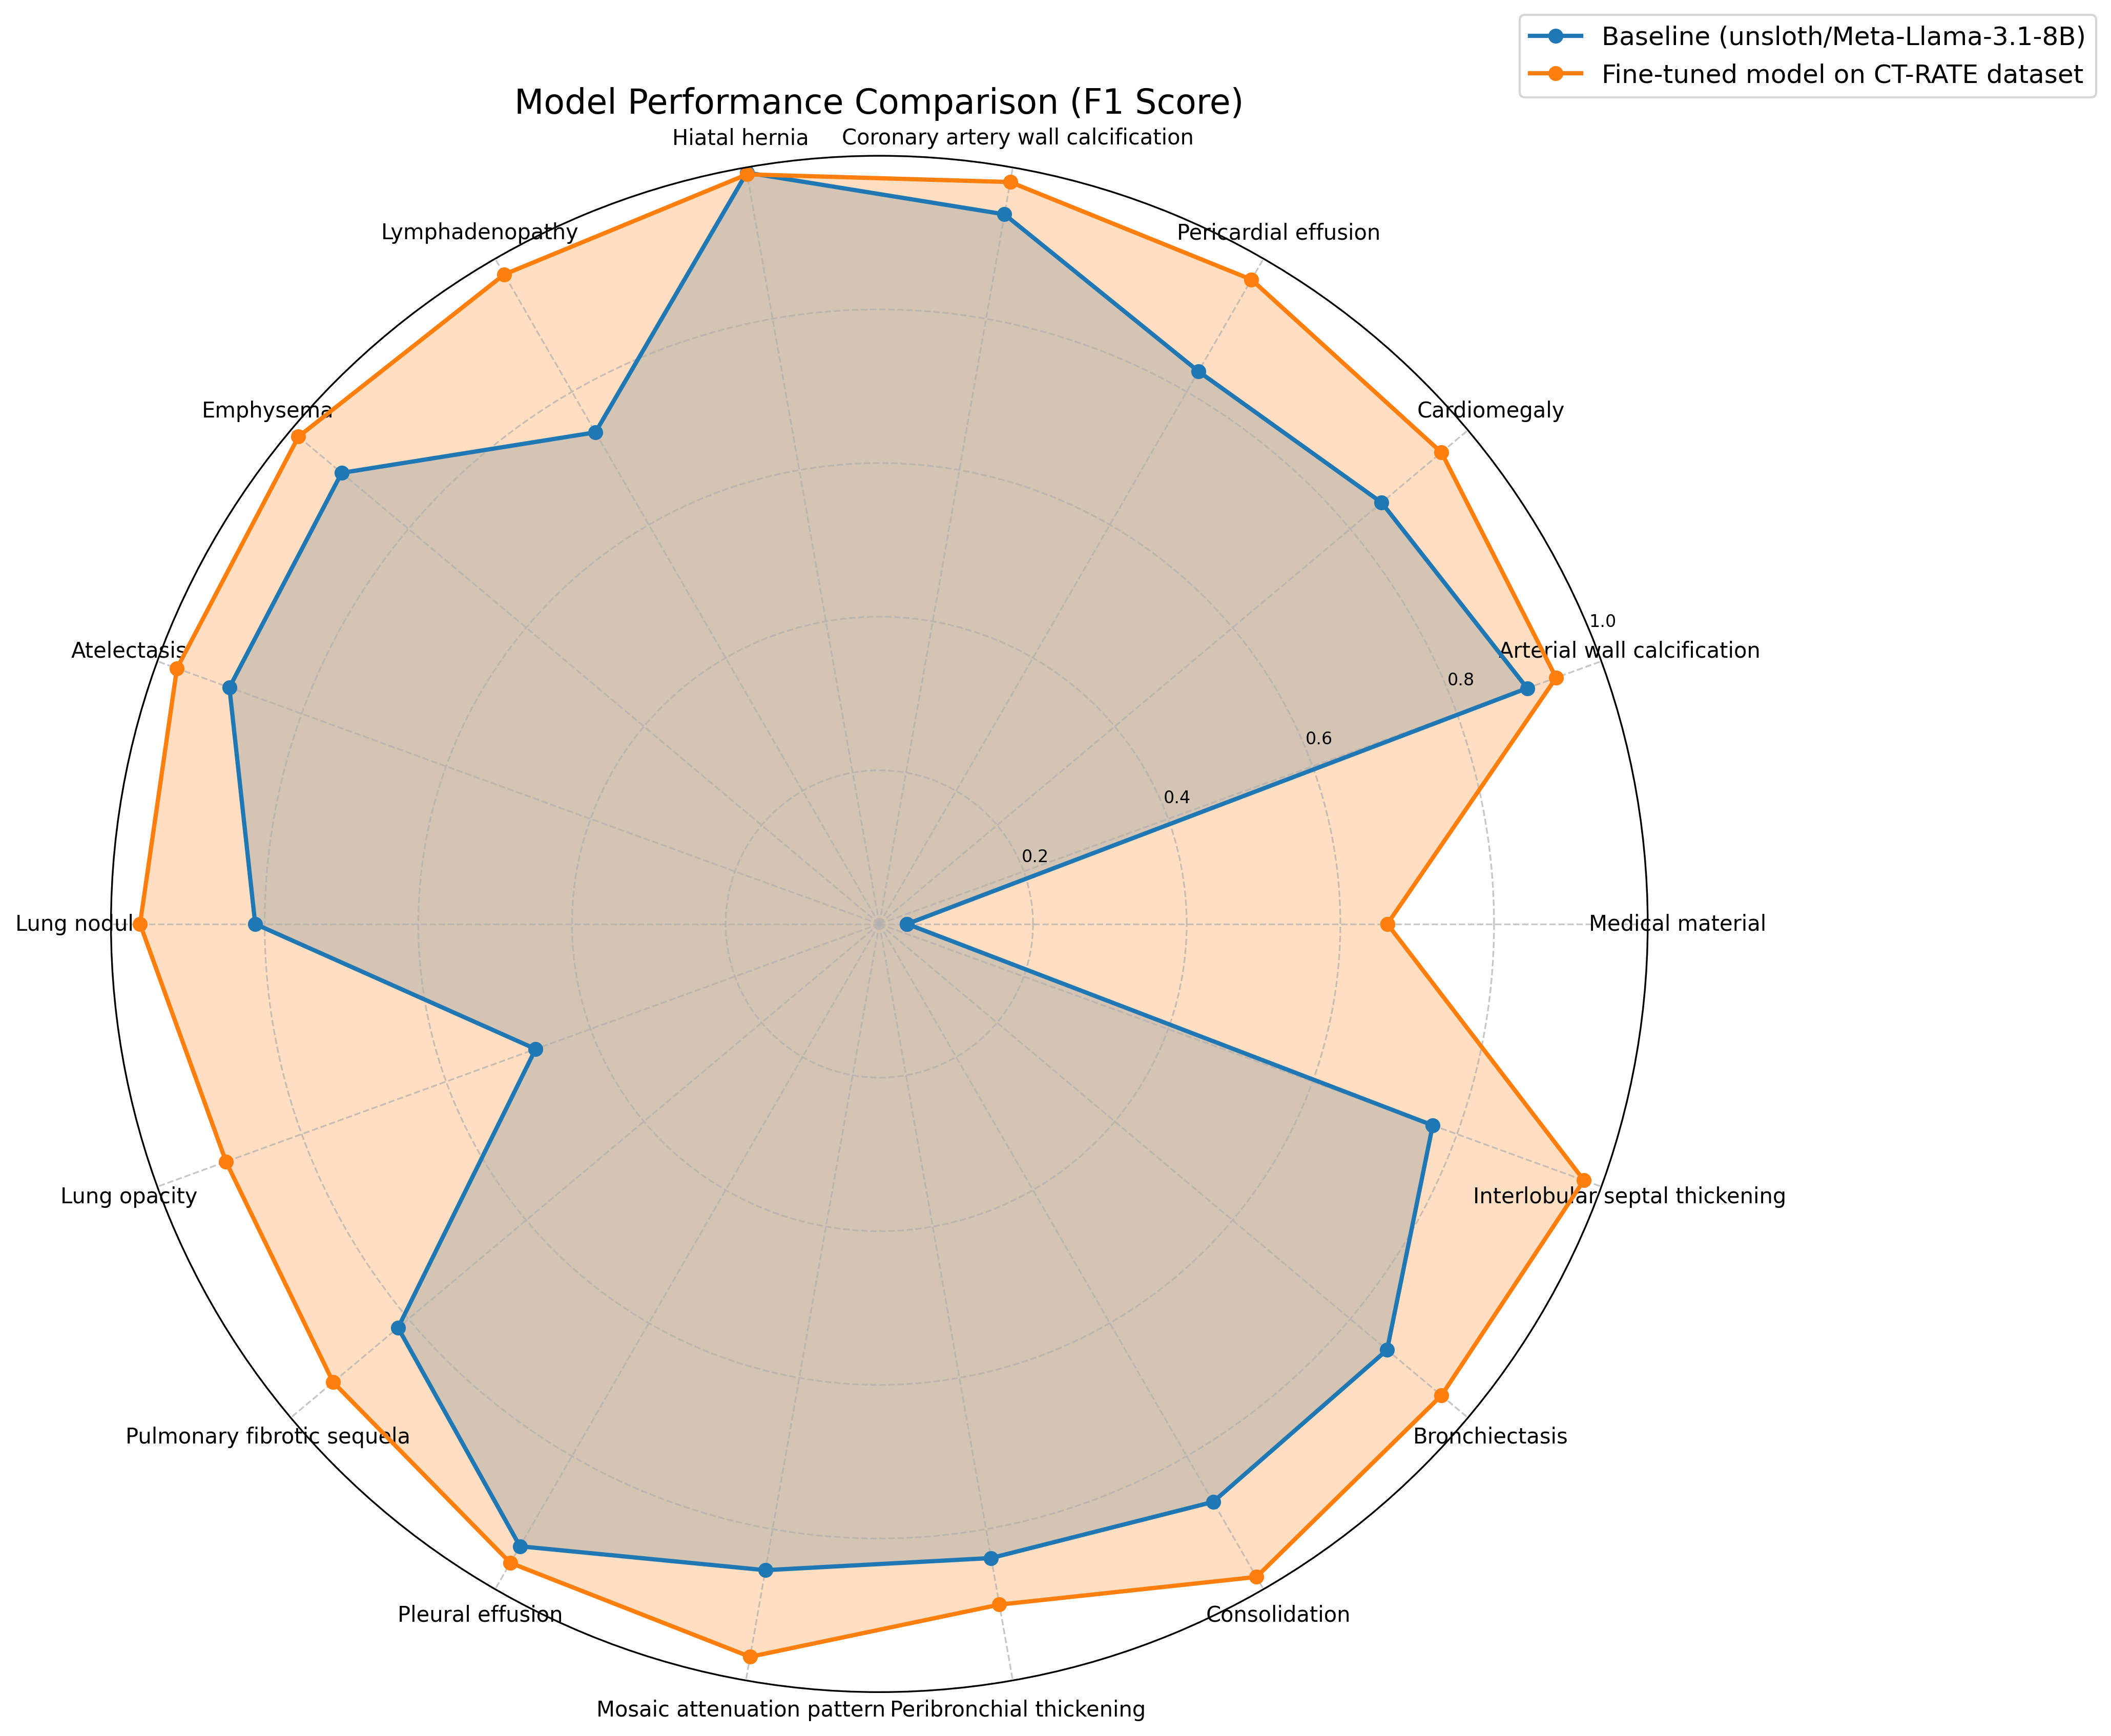